# IMAGE CLASSIFICATION OF 225 AVES SPECIES USING CNNs


In [1]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import pickle
from torch.optim.lr_scheduler import StepLR
import time

In [2]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
"""

# convert data to torch.FloatTensor:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

"""

"""
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()])

"""

After Experimenting with Various Transformations such as Horizonal and Vertical Flipping, Cropping, Normalization and Rotation, we found our models worked best on the unchanged data.

However, the images are cropped such that the birds occupy atleast 50% of the image.

Thus, the only transformation we apply to the images is to convert them to Tensors so that they can be used as inputs by the models.


In [5]:
# To perform Transformations to the Data
transform = transforms.ToTensor()

In [ ]:
# Local Path:
# tr_data_path = r"E:\ARSH\NEU\Udacity\Neural Networks\DataSets\225Birds\train"
# ts_data_path = r"E:\ARSH\NEU\Udacity\Neural Networks\DataSets\225Birds\test"

In [6]:
# Run if you want to unzip folders uploaded to drive (/content/drive/MyDrive/)

def get_path_from_drive(unzip = True):

  if unzip == True:
    !unzip /content/drive/MyDrive/Dataset/train.zip -d /content/drive/MyDrive/Dataset/
    !unzip /content/drive/MyDrive/Dataset/test.zip -d /content/drive/MyDrive/Dataset
    !unzip /content/drive/MyDrive/Dataset/valid.zip -d /content/drive/MyDrive/Dataset/

  tr_data_path = "/content/drive/MyDrive/Dataset/train"
  ts_data_path = "/content/drive/MyDrive/Dataset/test"
  vl_data_path = "/content/drive/MyDrive/Dataset/valid"

  return tr_data_path, ts_data_path, vl_data_path

tr_data_path, ts_data_path, vl_data_path = get_path_from_drive(False)

Since we have uploaded and unzipped our dataset on Drive, we will copy the folders to our current session since it is faster to read the files from the session rather than the drive.

This method still takes time.

In [ ]:
# Copy unzipped Data from Drive to Colab Sesh:

!cp "/content/drive/MyDrive/Dataset/test"  -r "/content/"
!cp "/content/drive/MyDrive/Dataset/train" -r "/content/"
!cp "/content/drive/MyDrive/Dataset/valid" -r "/content/"

***The best method is to upload the zipped files on the session and unzip the files.***

In [6]:
# Run if you want to unzip folders uploaded to the google colab session (/content/)

def get_path_from_session(unzip = False):

  if unzip == True:
    !unzip -uq train.zip
    !unzip -uq test.zip
    !unzip -uq valid.zip

  tr_data_path = "/content/train"
  ts_data_path = "/content/test"
  vl_data_path = "/content/valid"

  return tr_data_path, ts_data_path, vl_data_path

tr_data_path, ts_data_path, vl_data_path = get_path_from_session(False)


In [12]:
# Write and Read Lists:
# Used to Save Train and Test Losses for all Epochs

def write_lists(list_, fname):
  with open("/content/drive/MyDrive/Train_Test_Loss_Lists/" + fname, 'w') as f:
      for s in list_:
          f.write(str(s) + '\n')

def read_lists(fname):
  with open("/content/drive/MyDrive/Train_Test_Loss_Lists/" + fname, 'r') as f:
      list_ = [float(line.rstrip('\n')) for line in f]
  return list_


In [10]:
# Function to Display Sample Images:

def display_sample_images(dataloader, batch_size, sample_size, num_rows, class_dict):
  sample_size = min(sample_size, batch_size)
  images, labels = next(iter(dataloader))
  images = images.numpy()

  fig = plt.figure(figsize = (30, 10))
  for i in np.arange(sample_size):
      ax = fig.add_subplot(num_rows, sample_size/num_rows, i+1, xticks = [], yticks = [])
      ax.imshow(np.squeeze(np.transpose(images[i], (1, 2 ,0))))
      ax.set_title(str(class_dict[labels[i].item()]))
  
  return

In [9]:
# Training and Validating Model on Data:

def train(epoch, model, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf):
  # Training the model:
  start = time.time()
  model.train()
  train_losses, validation_losses = [], []
  for e in range(epochs):
      train_loss, validation_loss = 0.0, 0.0
      for images, labels in trainloader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()*images.size(0)
      
      # Validate the Model:
      for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        validation_loss += loss.item()*images.size(0)


      train_loss = train_loss/len(trainloader.dataset)
      validation_loss = train_loss/len(validloader.dataset)
      train_losses.append(train_loss)
      validation_losses.append(validation_loss)

      print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e+1, epochs, train_loss, validation_loss))
      
      if validation_loss <= valid_loss_min:
        print("Decrease in Validation Loss: {:.5f} to {:.5f}. Saving Model...".format(valid_loss_min, validation_loss))
        # torch.save(model.state_dict(), "/content/" + model_name + ".pt")
        torch.save(model.state_dict(), "/content/drive/MyDrive/Pretrained_Models/" + model_name + ".pt")
        valid_loss_min = validation_loss

  write_lists(train_losses, "train_losses_" + model_name)
  write_lists(validation_losses, "validation_losses_" + model_name) 
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  
  return train_losses, validation_losses


In [8]:
# Testing Model on Data:

def test(model, testloader, criterion, num_classes):

  test_loss, accuracy = 0.0, 0.0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  model.eval()

  for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      test_loss += loss.item()*images.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

      for i in range(len(labels)):
          label = labels.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(testloader.sampler)
  print("Test Loss: {}".format(test_loss))

  for i in range(num_classes):
      if class_total[i] > 0:
          print("Test Accuracy of {}: {:.3f}%. Frac: {}/{}".format(str(class_dict[i]), 100*(class_correct[i]/class_total[i]), 
                                                        np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print("Test Accuracy of {}: N/A (no training examples)".format(classes[i]))
  print("\n Test Accuracy (Overall): {:.3f}. Frac {}/{}".format((100 * np.sum(class_correct)/np.sum(class_total)), 
                                                            np.sum(class_correct), np.sum(class_total)))
  
  return
  

In [13]:
# Function to Load Trained Models:

def loadModel(model_name, model):
  state_dict = torch.load("/content/drive/MyDrive/Pretrained_Models/" + model_name + ".pt")
  model.load_state_dict(state_dict)
  return model

In [23]:
# Function to Display Predictions:

def display_predictions(cnn_name, model_name, testloader, class_dict):
  model = loadModel(model_name, cnn_name)
  model.cpu()
  images, labels = next(iter(testloader))
  output = model(images)
  pred_indices, preds = torch.max(output, 1)
  images = images.numpy()
  predicted_names = [class_dict[i.item()] for i in preds]
  labels_names = [class_dict[i.item()] for i in labels]
  fig = plt.figure(figsize = (60, 10))
  for i in np.arange(50):
      ax = fig.add_subplot(5, 50/5, i+1, xticks = [], yticks = [])
      ax.imshow(np.transpose(images[i], (1, 2, 0)), cmap = "gray")
      ax.set_title("{}:{}".format(str(predicted_names[i]), str(labels_names[i])),
                  color = ("green" if predicted_names[i] == labels_names[i] else "red"))

  return


In [14]:
# Function to Create Loss DF:

def create_loss_df(list_of_model_names):
  loss_dict = dict()
  for model_name in list_of_model_names:
    tname = "train_losses_{}".format(model_name)
    vname = "validation_losses_{}".format(model_name)
    train_loss = read_lists(tname)
    validation_loss = read_lists(vname)
    if model_name not in loss_dict:
      loss_dict[model_name] = {"train_loss": train_loss, "validation_loss": validation_loss}

  df_loss = pd.DataFrame.from_dict(loss_dict, orient = "index")
  return df_loss

In [17]:
# Function to Plot Losses:

def plot_losses(df_loss, list_of_model_names, loss_type):
  global_max, global_min = -np.Inf, np.Inf
  plt.figure(figsize = (16, 9))
  for model_name in list_of_model_names:
    plt.plot(df_loss.loc[model_name, loss_type], label = model_name.capitalize())
    min_ = min(df_loss.loc[model_name, loss_type])
    max_ = max(df_loss.loc[model_name, loss_type])
    if min_ <= global_min:
      global_min = min_
    if max_ >= global_max:
      global_max = max_
  plt.legend(frameon = False)
  if loss_type == "train_loss":
    plt.title("Epoch vs Training Loss")
    plt.yticks(np.arange(global_min, global_max, 0.1))
    plt.xticks(np.arange(0, 75, 2))
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
  elif loss_type == "validation_loss":
    plt.title("Epoch vs Validation Loss")
    plt.yticks(np.arange(global_min, global_max, 0.0005))
    plt.xticks(np.arange(0, 75, 2))
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
  else:
    print("Invalid Loss Type!")
  plt.show()
  return

Importing the data using DataLoaders:

In [12]:
train_data = datasets.ImageFolder(tr_data_path, transform = transform)
test_data = datasets.ImageFolder(ts_data_path, transform = transform)
valid_data = datasets.ImageFolder(vl_data_path, transform = transform)

trainloader = DataLoader(train_data, batch_size = 300, shuffle = True)
testloader = DataLoader(test_data, batch_size = 300, shuffle = True)
validloader = DataLoader(valid_data, batch_size = 300, shuffle = True)

In [8]:
test_data = datasets.ImageFolder(ts_data_path, transform = transform)
testloader = DataLoader(test_data, batch_size = 300, shuffle = True)

Creating a Class Mapper Dictionary


In [9]:
class_idx_dict = testloader.dataset.class_to_idx
class_dict = {i:name for name, i in class_idx_dict.items()}
print(class_dict)

{0: 'AFRICAN FIREFINCH', 1: 'ALBATROSS', 2: 'ALEXANDRINE PARAKEET', 3: 'AMERICAN AVOCET', 4: 'AMERICAN BITTERN', 5: 'AMERICAN COOT', 6: 'AMERICAN GOLDFINCH', 7: 'AMERICAN KESTREL', 8: 'AMERICAN PIPIT', 9: 'AMERICAN REDSTART', 10: 'ANHINGA', 11: 'ANNAS HUMMINGBIRD', 12: 'ANTBIRD', 13: 'ARARIPE MANAKIN', 14: 'ASIAN CRESTED IBIS', 15: 'BALD EAGLE', 16: 'BALI STARLING', 17: 'BALTIMORE ORIOLE', 18: 'BANANAQUIT', 19: 'BAR-TAILED GODWIT', 20: 'BARN OWL', 21: 'BARN SWALLOW', 22: 'BARRED PUFFBIRD', 23: 'BAY-BREASTED WARBLER', 24: 'BEARDED BARBET', 25: 'BELTED KINGFISHER', 26: 'BIRD OF PARADISE', 27: 'BLACK FRANCOLIN', 28: 'BLACK SKIMMER', 29: 'BLACK SWAN', 30: 'BLACK THROATED WARBLER', 31: 'BLACK VULTURE', 32: 'BLACK-CAPPED CHICKADEE', 33: 'BLACK-NECKED GREBE', 34: 'BLACK-THROATED SPARROW', 35: 'BLACKBURNIAM WARBLER', 36: 'BLUE GROUSE', 37: 'BLUE HERON', 38: 'BOBOLINK', 39: 'BROWN NOODY', 40: 'BROWN THRASHER', 41: 'CACTUS WREN', 42: 'CALIFORNIA CONDOR', 43: 'CALIFORNIA GULL', 44: 'CALIFORNIA QU

Visualizing A Sample of Images:


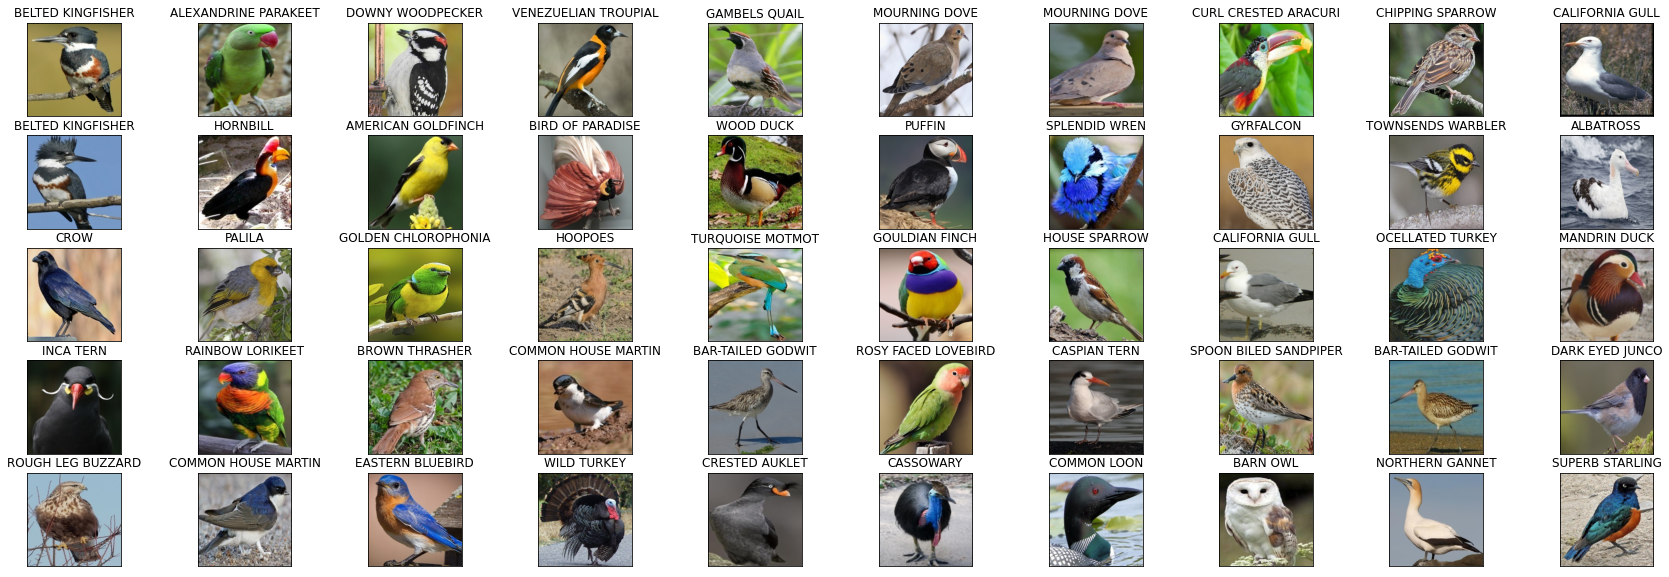

In [11]:
batch_size = 64
sample_size = 50
num_rows = 5
display_sample_images(testloader, batch_size, sample_size, num_rows, class_dict)


#### DENSENET 121

In [17]:
# Densenet121 Classifier

# Load Model:
densenet121 = models.densenet121(pretrained = True)

# Freeze Parameters so we dont backprop through them:
for param in densenet121.parameters():
    param.requires_grad = False
  
# Define Custom Classifier:
classifier = nn.Sequential(nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 225),
                           nn.LogSoftmax(dim = 1))

# Assign Classifier:
densenet121.classifier = classifier
densenet121.classifier

                        

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=225, bias=True)
  (4): LogSoftmax(dim=1)
)

#### DENSENET 161

In [15]:
# Densenet161 Classifier

densenet161 = models.densenet161(pretrained = True)
densenet161

# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False


# Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 225),
                           nn.LogSoftmax(dim = 1))

# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=225, bias=True)
  (4): LogSoftmax(dim=1)
)

#### SQUEEZENET 1.1


In [19]:
# Squeezenet Classifier:

squeezenet11 = models.squeezenet1_1(pretrained = True)
squeezenet11.classifier
squeezenet11.classifier[1] = nn.Conv2d(512, 225, kernel_size=(1,1), stride=(1,1))
squeezenet11.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 225, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

#### RESNET 152

In [20]:
# ResNet152 Classifier

resnet152 = models.resnet152(pretrained = True)
resnet152

# Freeze Parameters so we dont backprop through them:
for param in resnet152.parameters():
    param.requires_grad = False


# Create Custom Classifier:
# fc = nn.Sequential(nn.Linear(2048, 512),
#                    nn.ReLU(),
#                    nn.Dropout(0.20),
#                    nn.Linear(512, 225),
#                    nn.LogSoftmax(dim = 1))

fc2 = nn.Sequential(nn.Linear(2048, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.20),
                    nn.Linear(1024, 225),
                    nn.LogSoftmax(dim = 1))

# Assign Classifier
resnet152.fc = fc2
resnet152.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=225, bias=True)
  (4): LogSoftmax(dim=1)
)

#### RESNET 101

In [21]:
# ResNet101 Classifier

resnet101 = models.resnet101(pretrained = True)

# Freeze Parameters so we dont backprop through them:
for param in resnet101.parameters():
    param.requires_grad = False


# Create Custom Classifier:
# fc = nn.Sequential(nn.Linear(2048, 512),
#                    nn.ReLU(),
#                    nn.Dropout(0.20),
#                    nn.Linear(512, 225),
#                    nn.LogSoftmax(dim = 1))

fc2 = nn.Sequential(nn.Linear(2048, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.20),
                    nn.Linear(1024, 225),
                    nn.LogSoftmax(dim = 1))

# Assign Classifier
resnet101.fc = fc2
resnet101.fc


Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=225, bias=True)
  (4): LogSoftmax(dim=1)
)

#### WIDE RESNET 101 2

In [22]:
resnet101_2 = models.wide_resnet101_2(pretrained = True)

# Freeze Parameters so we dont backprop through them:
for param in resnet101_2.parameters():
    param.requires_grad = False


# Create Custom Classifier:
# fc = nn.Sequential(nn.Linear(2048, 512),
#                    nn.ReLU(),
#                    nn.Dropout(0.20),
#                    nn.Linear(512, 225),
#                    nn.LogSoftmax(dim = 1))

fc2 = nn.Sequential(nn.Linear(2048, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.20),
                    nn.Linear(1024, 225),
                    nn.LogSoftmax(dim = 1))

# Assign Classifier
resnet101_2.fc = fc2
resnet101_2.fc


Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=225, bias=True)
  (4): LogSoftmax(dim=1)
)

#### VGG 16

In [23]:
# VGG16 Classifier:

vgg16 = models.vgg16(pretrained = True)
vgg16

# Freeze Parameters so we dont backprop through them:
for param in vgg16.parameters():
    param.requires_grad = False

"""
classifier = nn.Sequential(nn.Linear(25088, 4096, bias = True),
                           nn.ReLU(inplace = True),
                           nn.Dropout(0.2),
                           nn.Linear(4096, 4096, bias = True),
                           nn.ReLU(inplace = True),
                           nn.Dropout(0.2),
                           nn.Linear(4096, 225, bias = True),
                           nn.LogSoftmax(dim = 1))

vgg16.classifier = classifier
vgg16.classifier

"""

vgg16.classifier[6] = nn.Linear(4096, 225, bias = True)
vgg16.classifier

# vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size = (2, 2))
# vgg16

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=225, bias=True)
)

#### TRAINING

In [ ]:
epochs = 75
valid_loss_min = np.Inf
for model, model_name in [(densenet121, "densenet121_new"), (densenet161, "densenet161_new"), (squeezenet11, "squeezenet1.1_new"), (resnet101, "resnet101_new"), (resnet101_2, "resnet101_2_new"), 
                          (vgg16, "vgg16_new"), (resnet152, "resnet152_new")]:
  start = time.time()
  print("Training {}".format(model_name.capitalize()))
  print("============================================================\n")
  if model == squeezenet11 or model == vgg16:
    criterion = nn.CrossEntropyLoss()
  else:
    criterion = nn.NLLLoss()
  
  if model == resnet152 or model == resnet101 or model == resnet101_2:
    optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)
  else:
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)

  model.to(device); # ";" prevents printing
  train_losses, validation_losses = train(epochs, model, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf)
  print("Time Taken for {} : {:.3f}s\n\n".format(model_name, time.time() - start))


Training Resnet101

Epoch: 1/75, Train Loss: 2.20910, Validation Loss: 0.00196
Decrease in Validation Loss: inf to 0.00196. Saving Model...
Epoch: 2/75, Train Loss: 0.71114, Validation Loss: 0.00063
Decrease in Validation Loss: 0.00196 to 0.00063. Saving Model...
Epoch: 3/75, Train Loss: 0.55488, Validation Loss: 0.00049
Decrease in Validation Loss: 0.00063 to 0.00049. Saving Model...
Epoch: 4/75, Train Loss: 0.47118, Validation Loss: 0.00042
Decrease in Validation Loss: 0.00049 to 0.00042. Saving Model...
Epoch: 5/75, Train Loss: 0.42158, Validation Loss: 0.00037
Decrease in Validation Loss: 0.00042 to 0.00037. Saving Model...
Epoch: 6/75, Train Loss: 0.37859, Validation Loss: 0.00034
Decrease in Validation Loss: 0.00037 to 0.00034. Saving Model...
Epoch: 7/75, Train Loss: 0.35709, Validation Loss: 0.00032
Decrease in Validation Loss: 0.00034 to 0.00032. Saving Model...
Epoch: 8/75, Train Loss: 0.32256, Validation Loss: 0.00029
Decrease in Validation Loss: 0.00032 to 0.00029. Saving M

#### TESTING

In [24]:
num_classes = 225
for model, model_name in [(squeezenet11, "squeezenet1.1"), (resnet101, "resnet101"), (resnet101_2, "resnet101_2"), (vgg16, "vgg16"), 
                          (resnet152, "resnet152"), (densenet121, "densenet121"), (densenet161, "densenet161"), (densenet161, "densenet161_2")]:
  print("\nTesting {}".format(model_name.capitalize()))
  print("==========================================================\n")
  model = loadModel(model_name, model)
  model.to(device)
  if model == resnet152 or model == resnet101 or model == resnet101_2:
    optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)
  else:
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)
  if model == squeezenet11 or model == vgg16:
    criterion = nn.CrossEntropyLoss()
  else:
    criterion = nn.NLLLoss()
  test(model, testloader, criterion, num_classes)
              


Testing Squeezenet1.1

Test Loss: 0.30890596840116713
Test Accuracy of AFRICAN FIREFINCH: 80.000%. Frac: 4.0/5.0
Test Accuracy of ALBATROSS: 80.000%. Frac: 4.0/5.0
Test Accuracy of ALEXANDRINE PARAKEET: 80.000%. Frac: 4.0/5.0
Test Accuracy of AMERICAN AVOCET: 100.000%. Frac: 5.0/5.0
Test Accuracy of AMERICAN BITTERN: 100.000%. Frac: 5.0/5.0
Test Accuracy of AMERICAN COOT: 100.000%. Frac: 5.0/5.0
Test Accuracy of AMERICAN GOLDFINCH: 80.000%. Frac: 4.0/5.0
Test Accuracy of AMERICAN KESTREL: 100.000%. Frac: 5.0/5.0
Test Accuracy of AMERICAN PIPIT: 100.000%. Frac: 5.0/5.0
Test Accuracy of AMERICAN REDSTART: 100.000%. Frac: 5.0/5.0
Test Accuracy of ANHINGA: 100.000%. Frac: 5.0/5.0
Test Accuracy of ANNAS HUMMINGBIRD: 100.000%. Frac: 5.0/5.0
Test Accuracy of ANTBIRD: 100.000%. Frac: 5.0/5.0
Test Accuracy of ARARIPE MANAKIN: 100.000%. Frac: 5.0/5.0
Test Accuracy of ASIAN CRESTED IBIS: 100.000%. Frac: 5.0/5.0
Test Accuracy of BALD EAGLE: 100.000%. Frac: 5.0/5.0
Test Accuracy of BALI STARLING: 

#### Visualizing Predicted Outputs

Title Of Images:
Predicted Species : Ground Truth

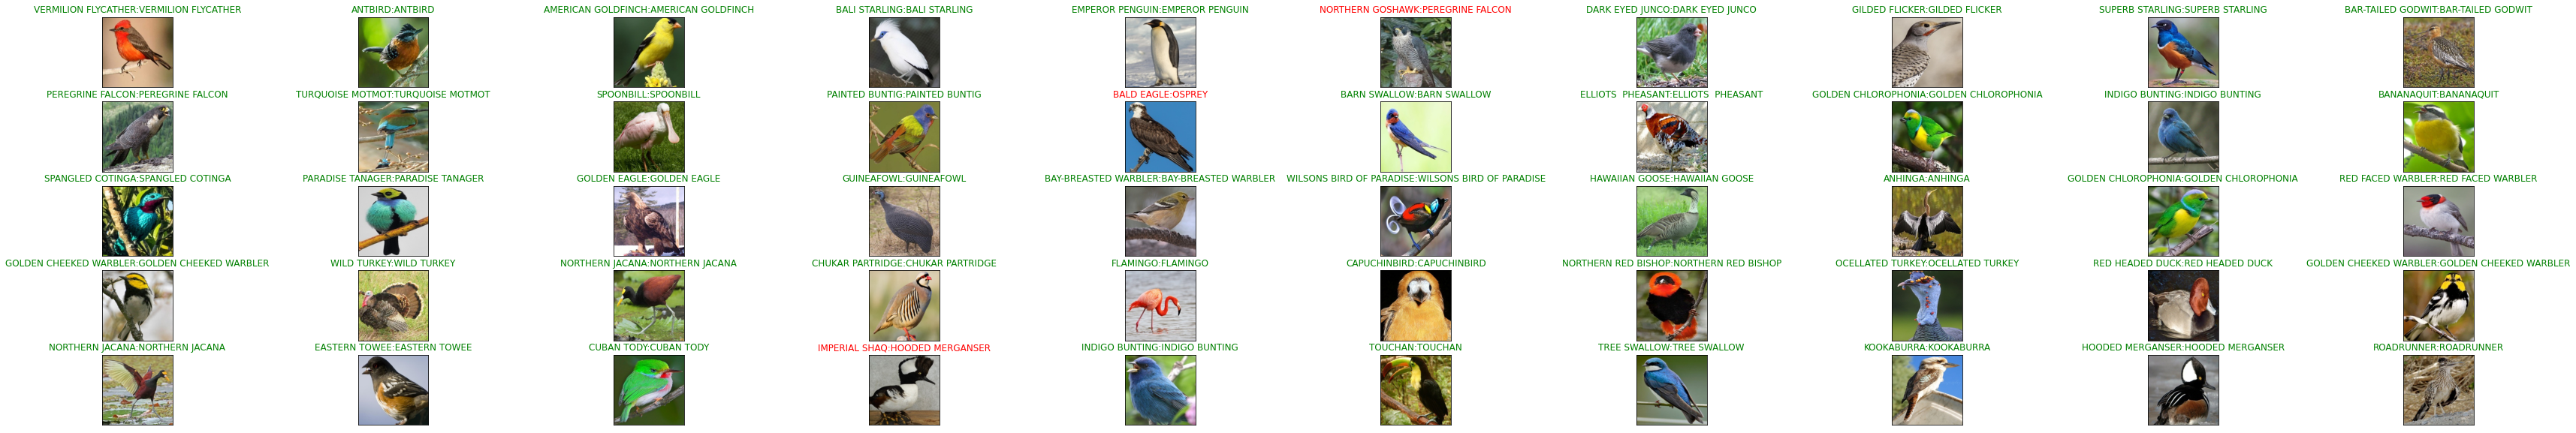

In [25]:
cnn_name = densenet161
model_name = "densenet161"
display_predictions(cnn_name, model_name, testloader, class_dict)

In [18]:
list_of_model_names = ["densenet121", "densenet161", "resnet101", "resnet101_2", "resnet152", "vgg16", "squeezenet1.1"]
df_loss = create_loss_df(list_of_model_names)

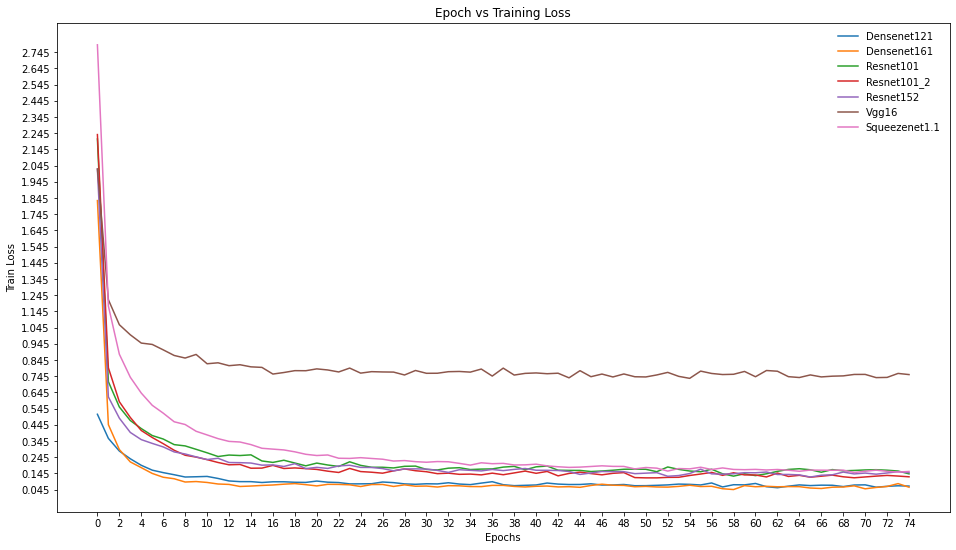

In [19]:
plot_losses(df_loss, list_of_model_names, "train_loss")

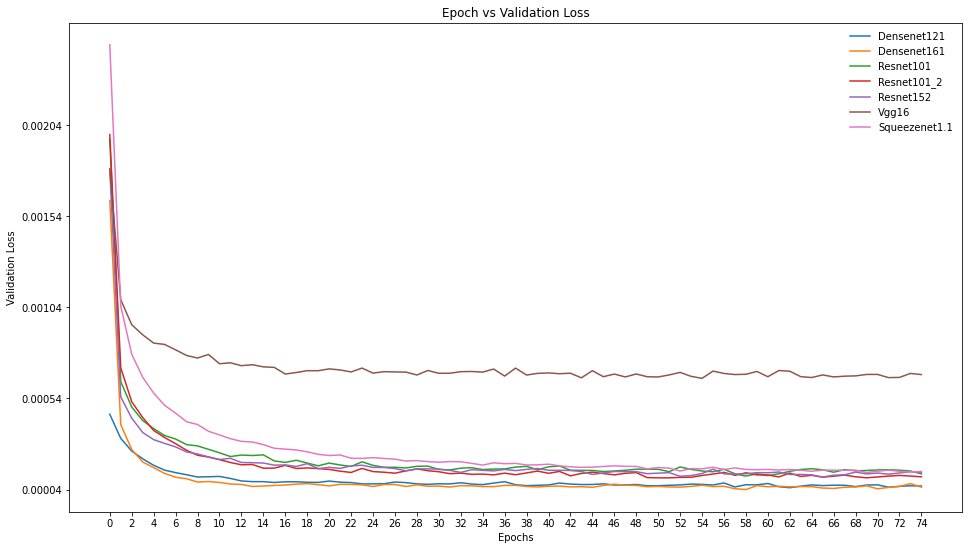

In [20]:
plot_losses(df_loss, list_of_model_names, "validation_loss")